# Deutsch Algorithm

In [1]:
import qiskit 

qiskit.__version__

'2.3.0'

In [2]:
#Define oracle function 
def oracle(kind: str) -> qiskit.QuantumCircuit:
    U = qiskit.QuantumCircuit(2, name=kind)

    """
    Our function f(x) maps {0,1} to {0,1} hence there are 4 possible states 
    f(x) = 0 will be represent as c0 
    f(x) = 1 will be represent as c1 

    f(x) = x will be represent as bx 
    f(x) = 1-x will be represent as bnx 

    Oracle act as |x,y> -> |x,y XOR f(x)>
    """

    if (kind == 'c0'): 
        #We will not do anything because y XOR 0 = y
        pass 

    elif (kind == "c1"):
        #y XOR 1 = NOT Y
        U.x(1) #Apply not gate on qubit indexed 1 

    elif (kind == "bx"):
        U.cx(0,1) 
        #y XOR x is the same as applying controlled not gate with x as control and y as target 
    
    elif (kind == "bnx"):
        U.x(1) 
        U.cx(0,1)
    
    else:
        raise ValueError ("Unknown function kind, please be sure that you defined a function that maps {0,1} to {0,1}")
    
    return U


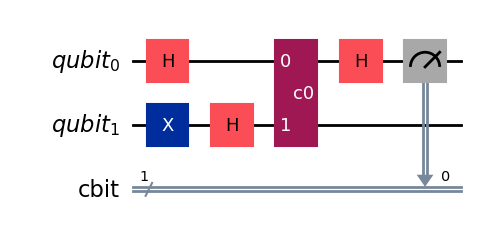

In [3]:
#Create the circuit
def deutsch(kind: str) -> qiskit.QuantumCircuit:
    qr = qiskit.QuantumRegister(2, name='qubit')
    cr = qiskit.ClassicalRegister(1, name='cbit')

    circuit = qiskit.QuantumCircuit(qr,cr)
    
    circuit.x(qr[1]) #Apply not gate to second qubit to start in |01>

    circuit.h([qr[0],qr[1]]) #Apply hadamard gate to all qubits to create superposition
    circuit.append(oracle(kind),[qr[0], qr[1]]) #Append our oracle to our circuit
    circuit.h(qr[0]) #Apply hadamard gate to first qubit to interference
    circuit.measure(qr[0],cr[0]) #Measure the value of first qubit and submit it into our classical bit 

    return circuit

#Example
deutsch('c0').draw('mpl')
    


In [4]:
#Simulate the circuit
from qiskit_aer import Aer 
from qiskit import transpile


backend = Aer.get_backend('aer_simulator')
kinds = ["c0", "c1", "bx", "bnx"]


for kind in kinds:
    qc = deutsch(kind)
    transpiled_circuit = transpile(qc, backend)
    res = backend.run(transpiled_circuit,shots=1024).result() 
    counts = res.get_counts()
    print(f"{kind:>3} -> {counts}") #0 means constant and 1 means balanced

 c0 -> {'0': 1024}
 c1 -> {'0': 1024}
 bx -> {'1': 1024}
bnx -> {'1': 1024}


In [5]:
#Visualization of the statevectors in bloch sphere 

import matplotlib.pyplot as plt 
from qiskit.quantum_info import Statevector

from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_city

%matplotlib inline

#We will rewrite the circuit again this time we will record statevectors in certain stages 
def deutsch(kind: str) -> qiskit.QuantumCircuit:
    qr = qiskit.QuantumRegister(2, name='qubit')
    cr = qiskit.ClassicalRegister(2, name='cbit')

    circuit = qiskit.QuantumCircuit(qr,cr)
    circuit.x(qr[1])
    base = circuit.copy()

    circuit.h([qr[0],qr[1]])
    after_hadamard = circuit.copy() 

    circuit.append(oracle(kind),[qr[0],qr[1]])
    after_oracle = circuit.copy()

    circuit.h(qr[0])
    before_measurement = circuit.copy()
 
    return base, after_hadamard, after_oracle, before_measurement


def bloch(label, qc):
    statevec = Statevector.from_label('00').evolve(qc)
    fig = plot_bloch_multivector(statevec)
    fig.suptitle(label, fontsize=14)
    plt.show()



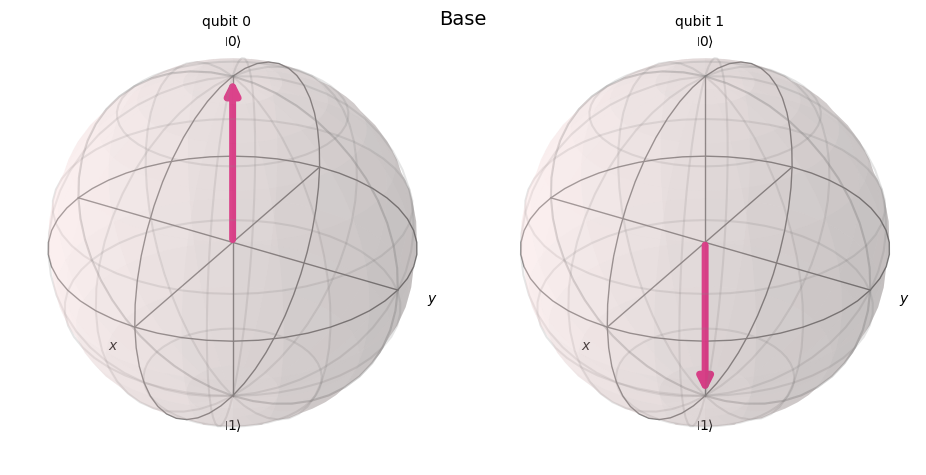

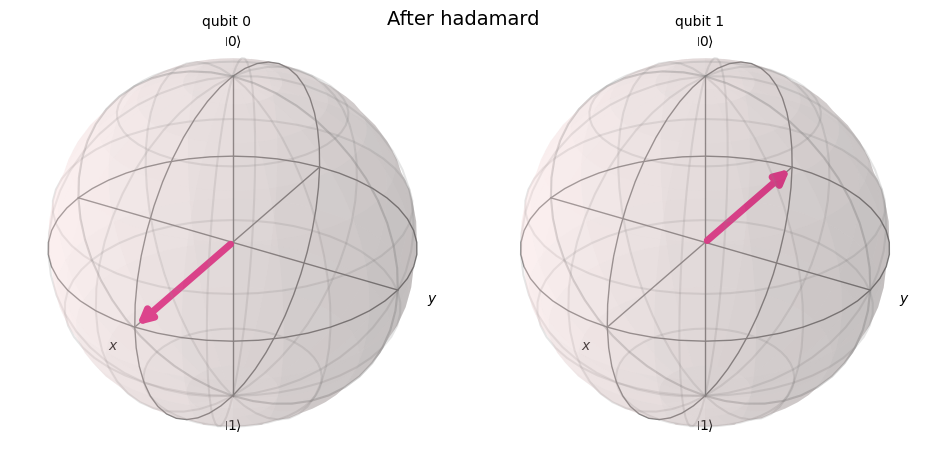

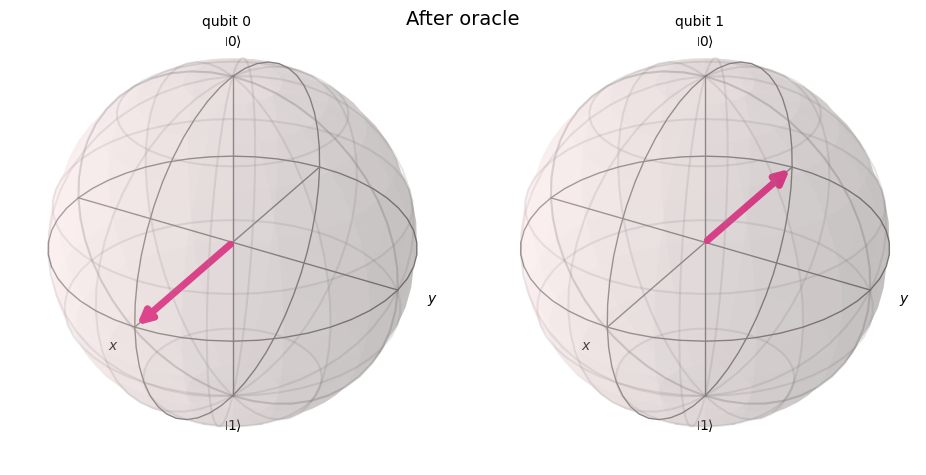

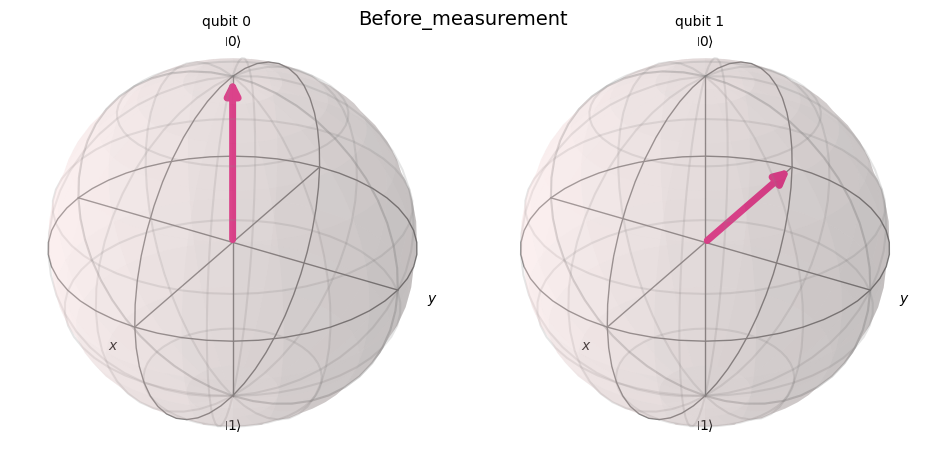

In [6]:

base,after_hadamard,after_oracle, before_measurement = deutsch('c0')
    
bloch('Base', base)
bloch('After hadamard', after_hadamard)
bloch('After oracle', after_oracle)
bloch('Before_measurement', before_measurement)
